# Jogeset Hálózat Elemzése
Ebben a notebookban a `graph_builder.py` szkript által létrehozott jogeset hálózatot elemezzük.

In [1]:
# Pip install parancsok futtatása
import sys
!{sys.executable} -m pip install nbformat>=4.2.0 community networkx matplotlib plotly pandas seaborn numpy

zsh:1: 4.2.0 not found


In [2]:
# Szükséges könyvtárak importálása
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import json
import os
import sys
import collections
from collections import Counter, defaultdict
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D  # Correct import for Line2D
import seaborn as sns
from community import community_louvain
import time
import nbformat

# Figyelmeztetések kikapcsolása
import warnings
warnings.filterwarnings('ignore')

# Projekt gyökérkönyvtár hozzáadása a path-hoz a config betöltéséhez
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Alapértelmezett elérési útvonalak
DEFAULT_GRAPH_PATH_GRAPHML = os.path.join(project_root, 'processed_data/graph_data/graph.graphml')
DEFAULT_GRAPH_PATH_JSON = os.path.join(project_root, 'processed_data/graph_data/graph.json')
DEFAULT_METADATA_PATH = os.path.join(project_root, 'processed_data/graph_data/graph_metadata.json')

GRAPH_PATH_GRAPHML = DEFAULT_GRAPH_PATH_GRAPHML
GRAPH_PATH_JSON = DEFAULT_GRAPH_PATH_JSON
METADATA_PATH = DEFAULT_METADATA_PATH

try:
    from configs import config
    # Biztonságos attribútum elérés getattr segítségével, alapértelmezett értékekkel
    GRAPH_PATH_GRAPHML = os.path.join(project_root, getattr(config, 'GRAPH_OUTPUT_GRAPHML_PATH', 'processed_data/graph_data/graph.graphml'))
    GRAPH_PATH_JSON = os.path.join(project_root, getattr(config, 'GRAPH_OUTPUT_JSON_PATH', 'processed_data/graph_data/graph.json'))
    METADATA_PATH = os.path.join(project_root, getattr(config, 'GRAPH_METADATA_PATH', 'processed_data/graph_data/graph_metadata.json'))
    print('Config file loaded successfully.')
except ImportError:
    print('Config file not found, using default paths.')
except Exception as e:
    print(f'Error loading config: {e}, using default paths.')

# Print actual paths being used
print(f"Using GraphML path: {GRAPH_PATH_GRAPHML}")
print(f"Using JSON path: {GRAPH_PATH_JSON}")
print(f"Using metadata path: {METADATA_PATH}")

# Matplotlib beállítások (opcionális)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

OpenAI API Key loaded successfully from environment.
Konfiguráció betöltve. Projekt gyökér: /Users/zelenyianszkimate/Documents/Szakdolgozat
Adat könyvtár: /Users/zelenyianszkimate/Documents/Szakdolgozat/data
Kimeneti könyvtár: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data
Nyers adat CSV: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/raw_data_for_eda.csv
Tisztított adat CSV: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/cleaned_data_for_embedding.csv
Feldolgozott Parquet: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/processed_documents_with_embeddings.parquet
OpenAI Embedding modell: text-embedding-3-small
Config file loaded successfully.
Using GraphML path: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/graph_data/graph.graphml
Using JSON path: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/graph_data/graph.json
Using metadata path: /Users/zelenyianszkimate/Documents/Szakdolgozat/proces

## Gráf Betöltése
Először megpróbáljuk betölteni a GraphML formátumú gráfot, amely kompaktabb és gyorsabb. Ha ez nem sikerül, akkor visszatérünk a JSON formátumhoz.

In [3]:
# Megpróbáljuk a GraphML formátumot betölteni, ha nem sikerül, akkor JSON-t használunk
try:
    # GraphML formátumú gráf betöltése
    G = nx.read_graphml(GRAPH_PATH_GRAPHML)
    print(f'GraphML gráf sikeresen betöltve: {GRAPH_PATH_GRAPHML}')
    print(f'Csomópontok száma: {G.number_of_nodes()}')
    print(f'Élek száma: {G.number_of_edges()}')
except Exception as e:
    print(f'Hiba a GraphML fájl betöltése közben: {e}')
    print('Megpróbáljuk a JSON formátumot betölteni...')
    
    try:
        # JSON formátumú gráf betöltése
        with open(GRAPH_PATH_JSON, 'r', encoding='utf-8') as f:
            graph_data = json.load(f)
        G = nx.node_link_graph(graph_data)
        print(f'JSON gráf sikeresen betöltve: {GRAPH_PATH_JSON}')
        print(f'Csomópontok száma: {G.number_of_nodes()}')
        print(f'Élek száma: {G.number_of_edges()}')
    except FileNotFoundError:
        print(f'Hiba: A JSON fájl nem található: {GRAPH_PATH_JSON}')
        G = None # Gráf inicializálása None-ra, ha a betöltés sikertelen
    except Exception as e:
        print(f'Hiba a JSON fájl betöltése közben: {e}')
        G = None

GraphML gráf sikeresen betöltve: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/graph_data/graph.graphml
Csomópontok száma: 1601344
Élek száma: 4097870
Élek száma: 4097870


## Metaadatok Betöltése

In [4]:
try:
    # Metaadatok betöltése a konfigurációból
    print(f"Metaadat betöltése: {METADATA_PATH}")
    with open(METADATA_PATH, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    print(f'Metaadatok sikeresen betöltve: {METADATA_PATH}')

    # Betöltött metaadatok megjelenítése
    print('\nBetöltött Metaadatok:')
    for key, value in metadata.items():
        print(f'- {key}: {value}')
except Exception as e:
    print(f'Hiba a metaadat fájl betöltése közben: {e}')
    metadata = None

Metaadat betöltése: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/graph_data/graph_metadata.json
Metaadatok sikeresen betöltve: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/graph_data/graph_metadata.json

Betöltött Metaadatok:
- generation_timestamp_utc: 2025-05-02T16:27:44.061976+00:00
- node_count: 1601344
- edge_count: 4097870
- stop_jogszabalyok_count: 484
- relation_types: ['hivatkozik', 'hivatkozik_jogszabalyra', 'targyalta']


## Alapvető Gráf Jellemzők
Kiírjuk a gráf alapvető jellemzőit, mint a csomópontok és élek száma, valamint az átlagos fokszám.

In [5]:
if G is not None:
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    if num_nodes > 0:
        # Fokszámok kiszámítása (be-, ki- és teljes fokszám irányított gráf esetén)
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        total_degrees = dict(G.degree())
        
        avg_in_degree = sum(in_degrees.values()) / num_nodes
        avg_out_degree = sum(out_degrees.values()) / num_nodes
        avg_total_degree = sum(total_degrees.values()) / num_nodes
        
        print(f'Átlagos bejövő fokszám: {avg_in_degree:.2f}')
        print(f'Átlagos kimenő fokszám: {avg_out_degree:.2f}')
        print(f'Átlagos teljes fokszám: {avg_total_degree:.2f}')
    else:
        print('A gráf üres, nincs csomópont.')
        
    # Gráf sűrűsége
    density = nx.density(G)
    print(f'Gráf sűrűsége: {density:.6f}')
else:
    print('A gráf nincs betöltve.')

Átlagos bejövő fokszám: 2.56
Átlagos kimenő fokszám: 2.56
Átlagos teljes fokszám: 5.12
Gráf sűrűsége: 0.000002
Gráf sűrűsége: 0.000002


## Csomópont Típusok Elemzése
Megszámoljuk a különböző típusú csomópontokat (pl. dokumentum, bíróság, jogszabály).

In [6]:
if G is not None:
    node_types = nx.get_node_attributes(G, 'type')
    type_counts = pd.Series(node_types).value_counts()
    
    print('Csomópont típusok eloszlása:')
    print(type_counts)
    
    # Oszlopdiagram a típusokról - dict_values helyett listát használunk
    fig = px.bar(type_counts, x=type_counts.index.tolist(), y=type_counts.values.tolist(), labels={'x':'Típus', 'y':'Darabszám'}, title='Csomópont Típusok Eloszlása')
    
    fig.show()
else:
    print('A gráf nincs betöltve.')

Csomópont típusok eloszlása:
jogszabaly    1211494
dokumentum     389687
birosag           163
Name: count, dtype: int64


## Fokszám Eloszlás Vizualizációja
Megvizsgáljuk a bejövő, kimenő és teljes fokszámok eloszlását.

Legmagasabb bejövő fokszámú csomópontok:
                                        node  in_degree
61                             birosag_kúria      52590
35              birosag_fővárosi_törvényszék      38262
32873            birosag_fővárosi_ítélőtábla      32762
587    birosag_budapest_környéki_törvényszék       8844
3407            birosag_debreceni_ítélőtábla       6448
Legmagasabb kimenő fokszámú csomópontok:
                     node  out_degree
654223   Mfv.10540/2018/7        3635
859221    Pf.20688/2021/6        2736
171179    Pf.20320/2017/6        1872
1467426    K.27366/2017/8         680
1467388    K.27028/2018/3         667
Legmagasabb teljes fokszámú csomópontok:
                                        node  total_degree
61                             birosag_kúria         52590
35              birosag_fővárosi_törvényszék         38262
32873            birosag_fővárosi_ítélőtábla         32762
587    birosag_budapest_környéki_törvényszék          8844
3407            bi

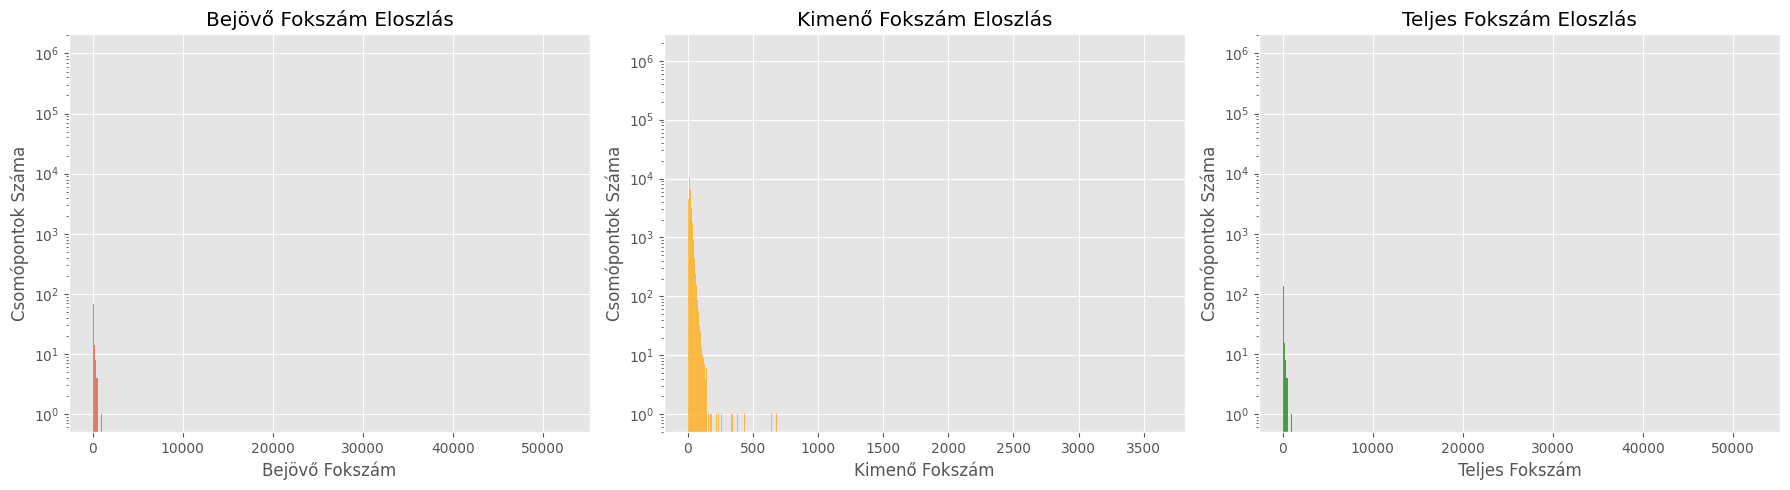

In [7]:
if G is not None and num_nodes > 0:
    # Adatkeretek létrehozása a fokszámokból
    in_degree_df = pd.DataFrame(in_degrees.items(), columns=['node', 'in_degree']).sort_values('in_degree', ascending=False)
    out_degree_df = pd.DataFrame(out_degrees.items(), columns=['node', 'out_degree']).sort_values('out_degree', ascending=False)
    total_degree_df = pd.DataFrame(total_degrees.items(), columns=['node', 'total_degree']).sort_values('total_degree', ascending=False)
    
    print('Legmagasabb bejövő fokszámú csomópontok:')
    print(in_degree_df.head())
    
    print('Legmagasabb kimenő fokszámú csomópontok:')
    print(out_degree_df.head())
    
    print('Legmagasabb teljes fokszámú csomópontok:')
    print(total_degree_df.head())
    
    # Hisztogramok
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(list(in_degrees.values()), bins=range(min(in_degrees.values()), max(in_degrees.values()) + 1, 1), alpha=0.7)
    plt.title('Bejövő Fokszám Eloszlás')
    plt.xlabel('Bejövő Fokszám')
    plt.ylabel('Csomópontok Száma')
    plt.yscale('log') # Logaritmikus skála hasznos lehet
    
    plt.subplot(1, 3, 2)
    plt.hist(list(out_degrees.values()), bins=range(min(out_degrees.values()), max(out_degrees.values()) + 1, 1), alpha=0.7, color='orange')
    plt.title('Kimenő Fokszám Eloszlás')
    plt.xlabel('Kimenő Fokszám')
    plt.ylabel('Csomópontok Száma')
    plt.yscale('log')
    
    plt.subplot(1, 3, 3)
    plt.hist(list(total_degrees.values()), bins=range(min(total_degrees.values()), max(total_degrees.values()) + 1, 1), alpha=0.7, color='green')
    plt.title('Teljes Fokszám Eloszlás')
    plt.xlabel('Teljes Fokszám')
    plt.ylabel('Csomópontok Száma')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
else:
    print('A gráf nincs betöltve vagy üres.')

## Gráf Vizualizáció (Minta)
Mivel a teljes gráf valószínűleg túl nagy a közvetlen vizualizációhoz, itt egy kisebb algráfot vagy egy mintát jelenítünk meg. Például a legmagasabb fokszámú csomópontok környezetét.
**Figyelem:** Nagy gráfok esetén ez a lépés lassú lehet és a kimenet átláthatatlan.

In [8]:
if G is not None and num_nodes > 0:
    # Kiválasztunk néhány központi csomópontot (pl. a legmagasabb fokszámúak)
    central_nodes = total_degree_df['node'].head(5).tolist() # Top 5 csomópont
    
    # Létrehozzuk az ego gráfokat ezekre a csomópontokra (csomópont + közvetlen szomszédok)
    subgraph_nodes = set(central_nodes)
    for node in central_nodes:
        subgraph_nodes.update(G.predecessors(node))
        subgraph_nodes.update(G.successors(node))
        
    # Csak a dokumentum típusú csomópontokat tartjuk meg a szomszédok közül (opcionális szűrés)
    # subgraph_nodes = {n for n in subgraph_nodes if G.nodes[n].get('type') == 'dokumentum' or n in central_nodes}
    
    sub_G = G.subgraph(subgraph_nodes)
    
    print(f'Algráf létrehozva {sub_G.number_of_nodes()} csomóponttal és {sub_G.number_of_edges()} éllel.')

    if sub_G.number_of_nodes() > 0 and sub_G.number_of_nodes() < 500: # Csak ésszerű méretű algráfot rajzolunk ki
        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(sub_G, k=0.3, iterations=50) # Elrendezés
        
        # Csomópontok színe típus szerint
        node_colors = []
        color_map = {'dokumentum': 'blue', 'jogszabaly': 'red', 'birosag': 'green'}
        for node in sub_G.nodes():
            node_type = G.nodes[node].get('type', 'unknown')
            node_colors.append(color_map.get(node_type, 'grey'))
            
        nx.draw(sub_G, pos, node_color=node_colors, with_labels=False, node_size=50, alpha=0.7, edge_color='gray')
        
        # Címkék csak a központi csomópontokhoz (opcionális, olvashatóság miatt)
        # labels = {n: n for n in central_nodes if n in sub_G}
        # nx.draw_networkx_labels(sub_G, pos, labels=labels, font_size=8)
        
        plt.title('Algráf Vizualizáció (Központi Csomópontok Környezete)')
        plt.show()
    elif sub_G.number_of_nodes() >= 500:
        print('Az algráf túl nagy a vizualizációhoz.')
    else:
        print('Nem sikerült algráfot létrehozni.')
else:
    print('A gráf nincs betöltve vagy üres.')

Algráf létrehozva 118384 csomóponttal és 138906 éllel.
Az algráf túl nagy a vizualizációhoz.


## További Elemzési Lehetőségek
*   **Centralitás mértékek:** PageRank, Betweenness Centrality, Eigenvector Centrality kiszámítása a legbefolyásosabb csomópontok azonosítására.
*   **Komponens analízis:** Erősen és gyengén összefüggő komponensek vizsgálata.
*   **Közösség detektálás:** Algoritmusok (pl. Louvain) futtatása a gráfban lévő közösségek (klaszterek) feltárására.
*   **Időbeli elemzés:** Ha az adatok tartalmaznak időbélyeget, az időbeli változások vizsgálata.

## Élek Típus Szerinti Elemzése

A `graph_builder.py` script különböző típusú kapcsolatokat definiál a csomópontok között, mint például "hivatkozik", "hivatkozik_jogszabalyra" és "targyalta". Itt részletesen elemezzük ezeket a kapcsolattípusokat.


--- Él típusok eloszlása ---
hivatkozik_jogszabalyra    3615689
hivatkozik                  241683
targyalta                   240498
Name: count, dtype: int64


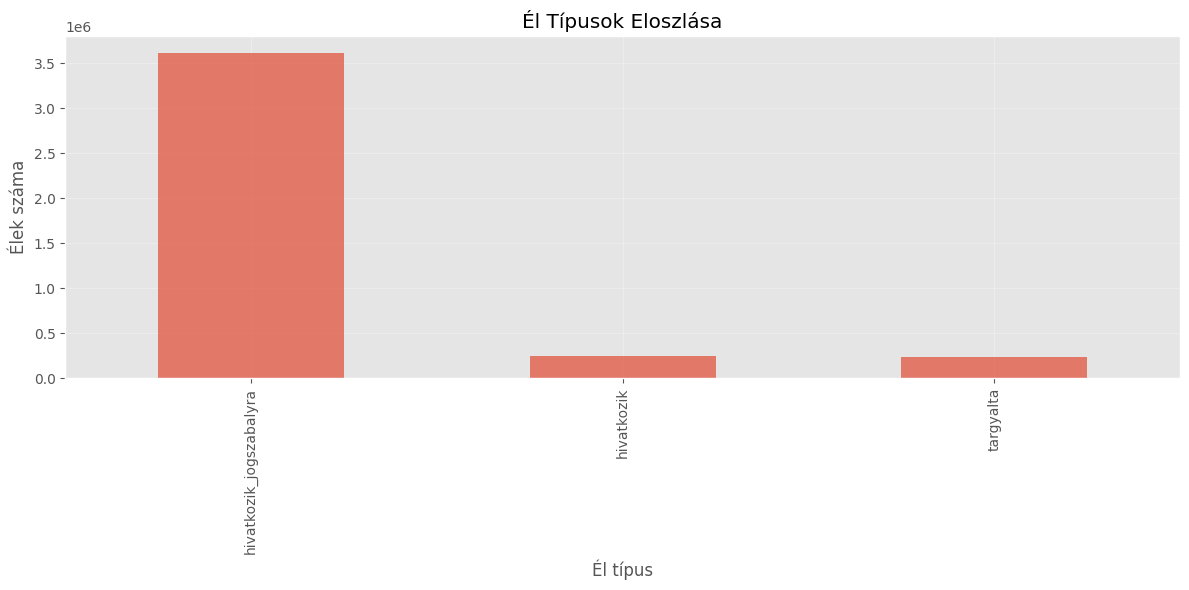


--- Él típusok csomópont típusok szerint ---


,relation_type,source_type,target_type,count
1,hivatkozik_jogszabalyra,dokumentum,jogszabaly,3615689
0,hivatkozik,dokumentum,dokumentum,241683
2,targyalta,dokumentum,birosag,240498



--- Él súlyok eloszlása ---
Átlagos súly: 1.22
Medián súly: 1.00
Maximum súly: 192
Minimum súly: 1


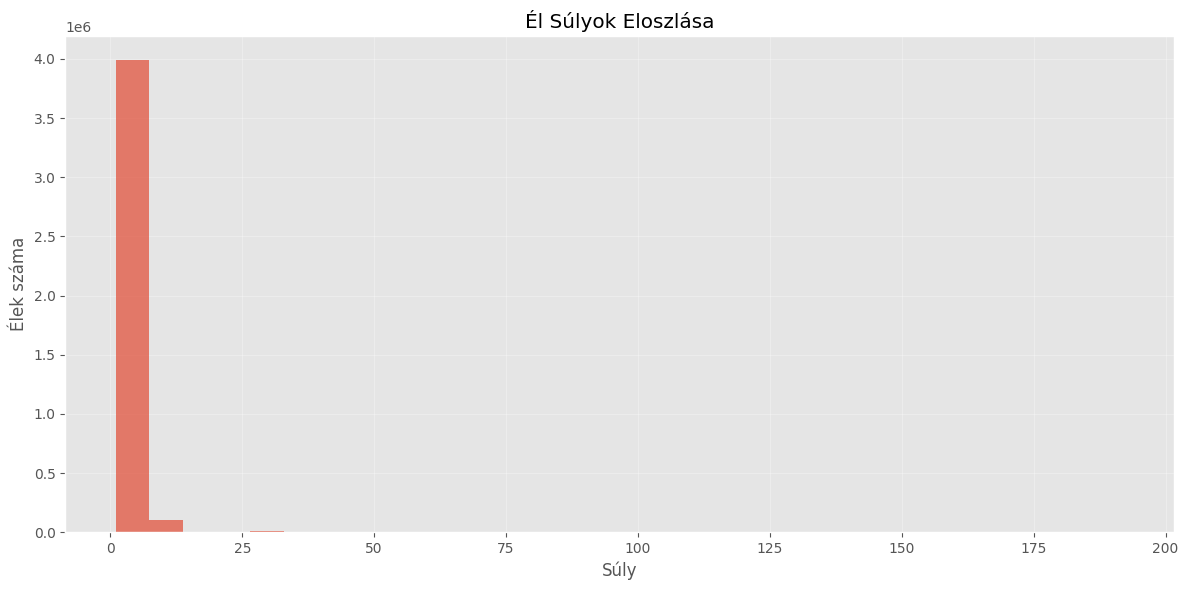


--- Él súlyok típusonként ---


,relation_type,avg_weight,median_weight,max_weight,count
2,hivatkozik_jogszabalyra,1.218219,1.0,192,3615689
0,hivatkozik,1.253311,1.0,64,241683
1,targyalta,1.259487,1.0,192,240498


In [9]:
if G is not None and G.number_of_nodes() > 0:
    # Él típusok kinyerése
    edge_relation_types = nx.get_edge_attributes(G, 'relation_type')
    
    if edge_relation_types:
        # Él típusok számlálása
        relation_type_counts = pd.Series(edge_relation_types.values()).value_counts()
        
        print(f"\n--- Él típusok eloszlása ---")
        print(relation_type_counts)
        
        # Vizualizáció: él típusok eloszlása
        plt.figure(figsize=(12, 6))
        relation_type_counts.plot(kind='bar', alpha=0.7)
        plt.title('Él Típusok Eloszlása')
        plt.xlabel('Él típus')
        plt.ylabel('Élek száma')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Él típusok vizsgálata csomópont típusok szerint
        edge_type_node_type = []
        for (u, v), rel_type in edge_relation_types.items():
            u_type = node_types.get(u, 'unknown')
            v_type = node_types.get(v, 'unknown')
            edge_type_node_type.append((rel_type, u_type, v_type))
        
        # Élek csoportosítása
        edge_type_df = pd.DataFrame(edge_type_node_type, columns=['relation_type', 'source_type', 'target_type'])
        edge_type_summary = edge_type_df.groupby(['relation_type', 'source_type', 'target_type']).size().reset_index(name='count')
        edge_type_summary = edge_type_summary.sort_values('count', ascending=False)
        
        print("\n--- Él típusok csomópont típusok szerint ---")
        display(edge_type_summary.head(20))  # Top 20 leggyakoribb kategória
        
        # Él súlyok elemzése, ha vannak
        edge_weights = nx.get_edge_attributes(G, 'weight')
        if edge_weights:
            weights = list(edge_weights.values())
            
            print(f"\n--- Él súlyok eloszlása ---")
            print(f"Átlagos súly: {np.mean(weights):.2f}")
            print(f"Medián súly: {np.median(weights):.2f}")
            print(f"Maximum súly: {max(weights)}")
            print(f"Minimum súly: {min(weights)}")
            
            plt.figure(figsize=(12, 6))
            plt.hist(weights, bins=30, alpha=0.7)
            plt.title('Él Súlyok Eloszlása')
            plt.xlabel('Súly')
            plt.ylabel('Élek száma')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Él súlyok típusonként
            edge_weights_by_type = defaultdict(list)
            for (u, v), weight in edge_weights.items():
                if (u, v) in edge_relation_types:
                    rel_type = edge_relation_types[(u, v)]
                    edge_weights_by_type[rel_type].append(weight)
            
            # Él súlyok összesítése típusonként
            weight_summary = {}
            for rel_type, weights_list in edge_weights_by_type.items():
                if weights_list:  # Ellenőrizzük, hogy a lista nem üres
                    weight_summary[rel_type] = {
                        'avg': np.mean(weights_list),
                        'med': np.median(weights_list),
                        'max': max(weights_list),
                        'count': len(weights_list)
                    }
            
            weight_df = pd.DataFrame([
                {'relation_type': rel_type, 
                 'avg_weight': stats['avg'],
                 'median_weight': stats['med'],
                 'max_weight': stats['max'],
                 'count': stats['count']}
                for rel_type, stats in weight_summary.items()
            ])
            
            print("\n--- Él súlyok típusonként ---")
            display(weight_df.sort_values('count', ascending=False))
    else:
        print("A gráfban nem találhatóak él típus attribútumok (relation_type).")
else:
    print('A gráf nincs betöltve vagy üres.')

## Többrétegű Hálózatelemzés és Motívumok Vizsgálata

A többrétegű hálózatelemzés segítségével külön vizsgálhatjuk a különböző típusú kapcsolatokat (rétegeket) a gráfban. Jogeset hálózatoknál különösen fontos lehet a különböző típusú hivatkozások vagy kapcsolatok vizsgálata. Emellett a motívum detektálás segítségével gyakori kapcsolati mintákat azonosítunk a gráf struktúrában.

Többrétegű hálózatelemzés...
Összesen 3 különböző kapcsolattípus található:
- hivatkozik
- hivatkozik_jogszabalyra
- targyalta

--- Rétegenkénti alapstatisztikák ---

--- Rétegenkénti alapstatisztikák ---


,nodes,edges,density,components,largest_component_size,largest_component_ratio
hivatkozik_jogszabalyra,1424430,3615689,0.000002,4227,1396800,98.06%
targyalta,174474,240498,0.000008,1,174474,100.00%
hivatkozik,350579,241683,0.000002,130188,17,0.00%


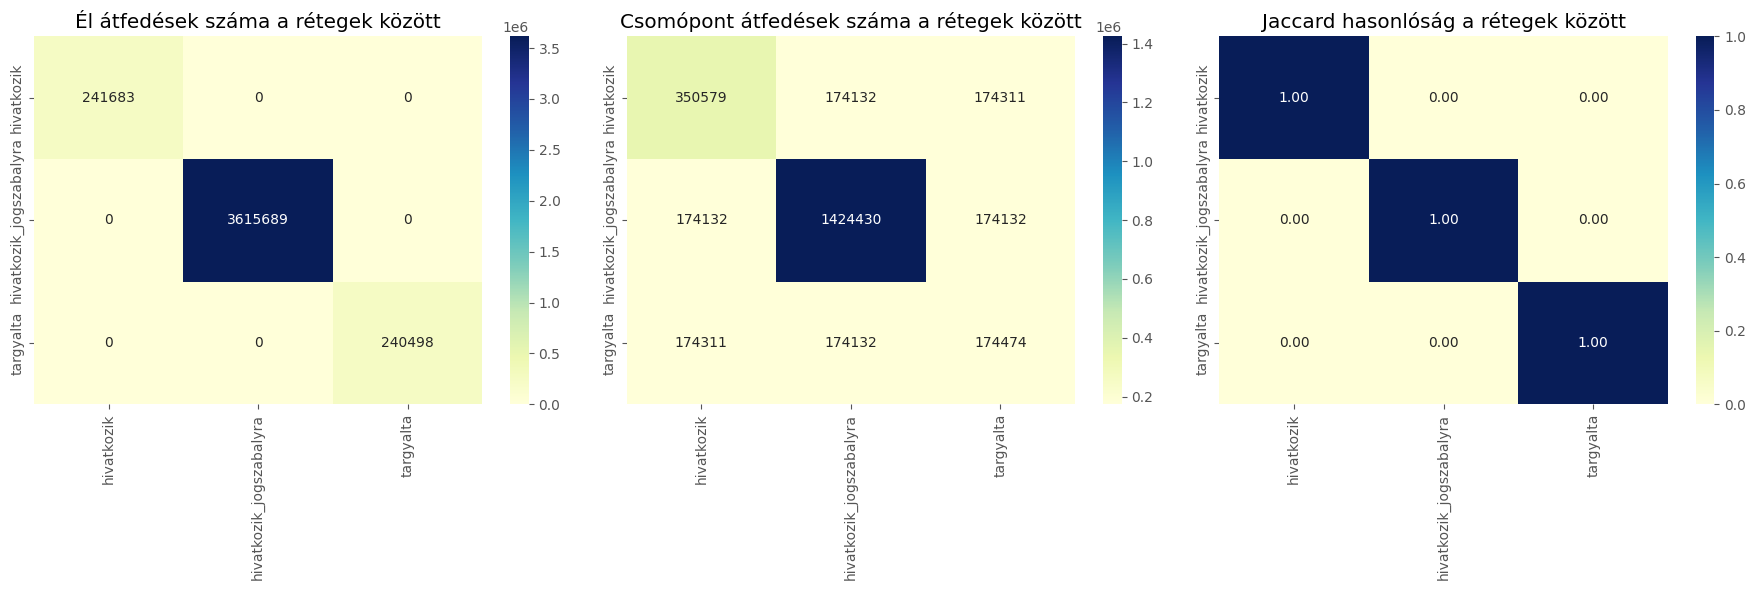


--- Gyakori gráf motívumok detektálása ---
A motívumok kis, ismétlődő kapcsolati minták a hálózatban.
Mintavétel a gráfból (200 csomópontra)...
Létrehozott minta: 200 csomópont, 225 él

3-csomópontú motívumok (triádok) száma a mintában:
Létrehozott minta: 200 csomópont, 225 él

3-csomópontú motívumok (triádok) száma a mintában:


,Motívum,Darabszám
0,003,1270726
1,012,40798
4,021U,1772
3,021D,104
2,102,0
5,021C,0
6,111D,0
7,111U,0
8,030T,0
9,030C,0


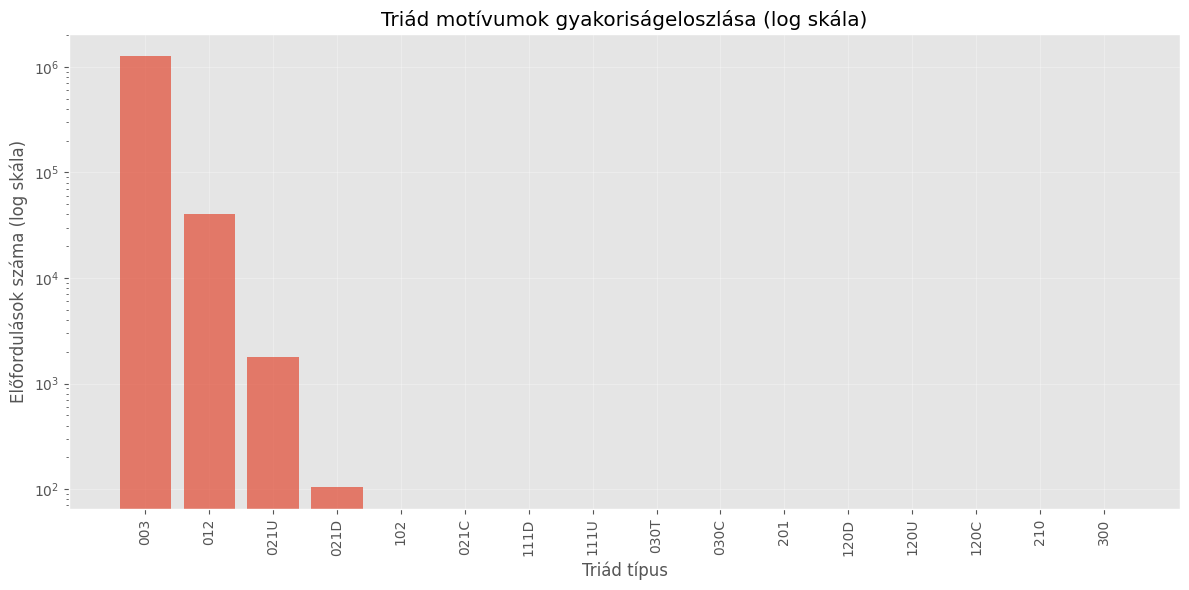


Tranzitivitás a mintában: 0.0000
(0: nincs tranzitivitás, 1: teljes tranzitivitás)

Átlagos clustering coefficient: 0.0000

Top 5 legmagasabb clustering együtthatóval rendelkező csomópont:
- K.30327/2013/27 (dokumentum): 0.0000 clustering együttható
- P.21137/2009/98 (dokumentum): 0.0000 clustering együttható
- M.2234/2012/16 (dokumentum): 0.0000 clustering együttható
- Pkf.25585/2020/7 (dokumentum): 0.0000 clustering együttható
- Pf.21037/2016/4 (dokumentum): 0.0000 clustering együttható


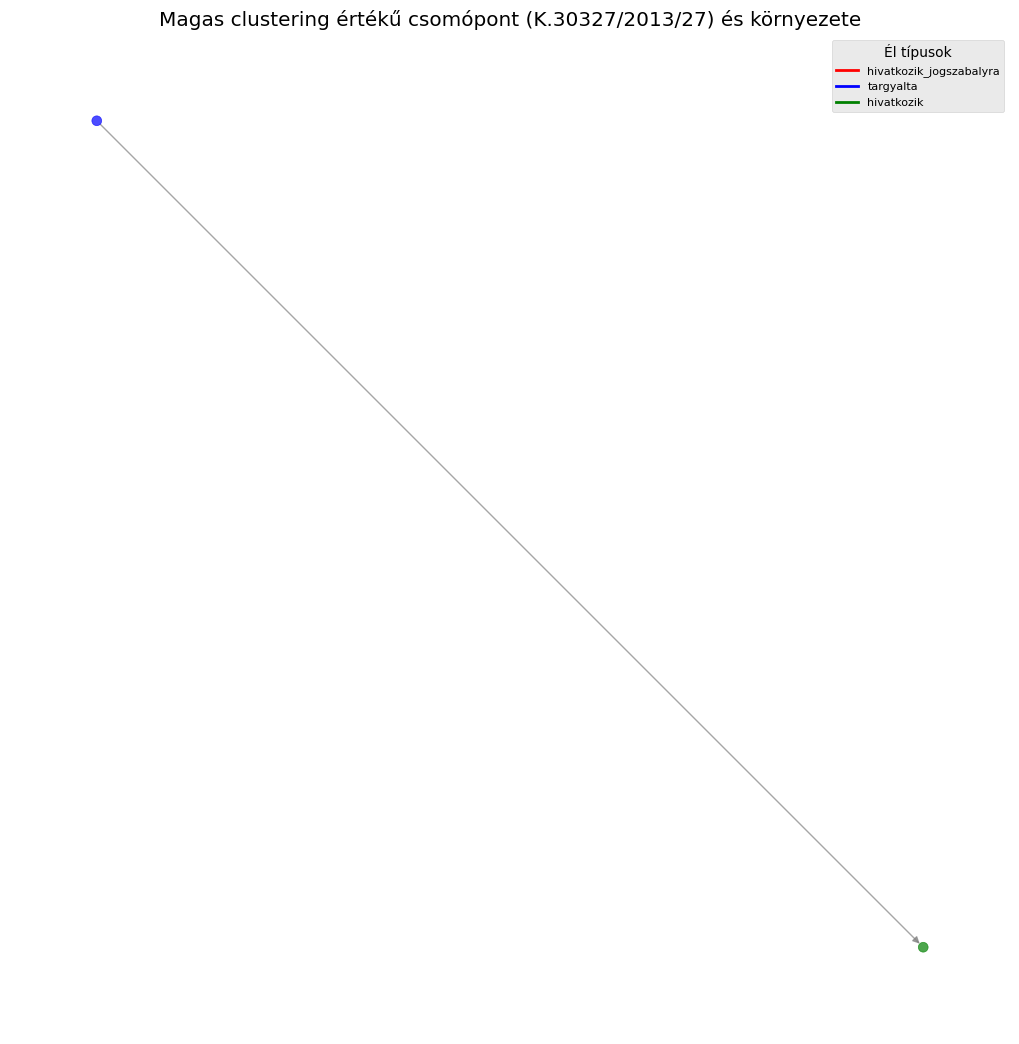

In [10]:
if G is not None and G.number_of_nodes() > 0:
    # Él típusok kinyerése és rétegekre bontás
    edge_types = nx.get_edge_attributes(G, 'relation_type')
    
    if edge_types:
        print("Többrétegű hálózatelemzés...")
        unique_edge_types = set(edge_types.values())
        print(f"Összesen {len(unique_edge_types)} különböző kapcsolattípus található:")
        for et in sorted(unique_edge_types):
            print(f"- {et}")
        
        # Létrehozzuk a különböző rétegeket képviselő algráfokat
        layer_graphs = {}
        layer_stats = {}
        
        for edge_type in unique_edge_types:
            # Az adott típusú éleket tartalmazó algráf
            layer_edges = [(u, v) for (u, v), rel_type in edge_types.items() if rel_type == edge_type]
            if layer_edges:
                layer_G = G.edge_subgraph(layer_edges).copy()
                layer_graphs[edge_type] = layer_G
                
                # Alapvető statisztikák az algráfról
                n_nodes = layer_G.number_of_nodes()
                n_edges = layer_G.number_of_edges()
                density = nx.density(layer_G)
                
                # Gyengén összefüggő komponensek
                wcc = list(nx.weakly_connected_components(layer_G)) if layer_G.is_directed() else list(nx.connected_components(layer_G))
                largest_wcc_size = len(max(wcc, key=len)) if wcc else 0
                
                layer_stats[edge_type] = {
                    'nodes': n_nodes,
                    'edges': n_edges,
                    'density': density,
                    'components': len(wcc),
                    'largest_component_size': largest_wcc_size,
                    'largest_component_ratio': largest_wcc_size / n_nodes if n_nodes > 0 else 0
                }
        
        # Statisztikák megjelenítése
        stats_df = pd.DataFrame.from_dict(layer_stats, orient='index')
        stats_df['density'] = stats_df['density'].apply(lambda x: f"{x:.6f}")
        stats_df['largest_component_ratio'] = stats_df['largest_component_ratio'].apply(lambda x: f"{x:.2%}")
        
        print("\n--- Rétegenkénti alapstatisztikák ---")
        display(stats_df)
        
        # Vizualizáljuk a rétegek közötti átfedéseket heatmap-en
        # Edge overlap: Két réteg közötti él-átfedés mértéke
        edge_overlap = np.zeros((len(unique_edge_types), len(unique_edge_types)))
        edge_type_list = sorted(unique_edge_types)
        
        for i, type1 in enumerate(edge_type_list):
            for j, type2 in enumerate(edge_type_list):
                if i == j:  # Átló: saját méret
                    edge_overlap[i, j] = layer_graphs[type1].number_of_edges()
                else:  # Átfedés
                    edges1 = set(layer_graphs[type1].edges())
                    edges2 = set(layer_graphs[type2].edges())
                    intersection = edges1.intersection(edges2)
                    edge_overlap[i, j] = len(intersection)
        
        # Node overlap: Csomópontok átfedése két réteg között
        node_overlap = np.zeros((len(unique_edge_types), len(unique_edge_types)))
        
        for i, type1 in enumerate(edge_type_list):
            for j, type2 in enumerate(edge_type_list):
                if i == j:  # Átló: saját méret
                    node_overlap[i, j] = layer_graphs[type1].number_of_nodes()
                else:  # Átfedés
                    nodes1 = set(layer_graphs[type1].nodes())
                    nodes2 = set(layer_graphs[type2].nodes())
                    intersection = nodes1.intersection(nodes2)
                    node_overlap[i, j] = len(intersection)
        
        # Jaccard hasonlóság számítása a rétegek között
        jaccard_similarity = np.zeros((len(unique_edge_types), len(unique_edge_types)))
        
        for i, type1 in enumerate(edge_type_list):
            for j, type2 in enumerate(edge_type_list):
                if i == j:
                    jaccard_similarity[i, j] = 1.0  # Saját magával való hasonlóság: 1
                else:
                    edges1 = set(layer_graphs[type1].edges())
                    edges2 = set(layer_graphs[type2].edges())
                    intersection = len(edges1.intersection(edges2))
                    union = len(edges1.union(edges2))
                    jaccard_similarity[i, j] = intersection / union if union > 0 else 0
        
        # Vizualizáció
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        sns.heatmap(edge_overlap, annot=True, fmt=".0f", cmap="YlGnBu",
                   xticklabels=edge_type_list, yticklabels=edge_type_list)
        plt.title('Él átfedések száma a rétegek között')
        
        plt.subplot(1, 3, 2)
        sns.heatmap(node_overlap, annot=True, fmt=".0f", cmap="YlGnBu",
                   xticklabels=edge_type_list, yticklabels=edge_type_list)
        plt.title('Csomópont átfedések száma a rétegek között')
        
        plt.subplot(1, 3, 3)
        sns.heatmap(jaccard_similarity, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1,
                   xticklabels=edge_type_list, yticklabels=edge_type_list)
        plt.title('Jaccard hasonlóság a rétegek között')
        
        plt.tight_layout()
        plt.show()
        
        # Motívumok detektálása egy kisebb mintán
        print("\n--- Gyakori gráf motívumok detektálása ---")
        print("A motívumok kis, ismétlődő kapcsolati minták a hálózatban.")
        
        # Minta létrehozása a motívum kereséshez (nagy gráfra ez exponenciálisan skálázódik)
        max_sample_size = 200  # Motívum kereséshez kisebb méret kell
        
        if G.number_of_nodes() > max_sample_size:
            # Mintavétel: fokszám szerint legfontosabb csomópontok és környezetük
            print(f"Mintavétel a gráfból ({max_sample_size} csomópontra)...")
            deg_centrality = nx.degree_centrality(G)
            sorted_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
            # Top 10% csomópont kiválasztása
            top_nodes = [node for node, _ in sorted_nodes[:max_sample_size//10]]
            
            # Ego gráfok létrehozása a kiválasztott csomópontokra
            sample_nodes = set(top_nodes)
            for node in top_nodes:
                neighbors = set(G.successors(node)).union(set(G.predecessors(node)))
                sample_nodes.update(list(neighbors)[:10])  # Maximum 10 szomszéd per csomópont
                if len(sample_nodes) >= max_sample_size:
                    break
            
            sample_nodes = list(sample_nodes)[:max_sample_size]
            G_sample = G.subgraph(sample_nodes)
            print(f"Létrehozott minta: {G_sample.number_of_nodes()} csomópont, {G_sample.number_of_edges()} él")
        else:
            G_sample = G
            print(f"A teljes gráf használata: {G_sample.number_of_nodes()} csomópont, {G_sample.number_of_edges()} él")
        
        # Irányított 3-csomópontú motívumok keresése
        try:
            from networkx.algorithms import triads
            triad_census = triads.triadic_census(G_sample)
            
            # Triad típusokról bővebben: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.triads.triadic_census.html
            print("\n3-csomópontú motívumok (triádok) száma a mintában:")
            triad_df = pd.DataFrame({
                'Motívum': list(triad_census.keys()),
                'Darabszám': list(triad_census.values())
            }).sort_values('Darabszám', ascending=False)
            display(triad_df)
            
            # Triádok vizualizálása
            plt.figure(figsize=(12, 6))
            plt.bar(triad_df['Motívum'], triad_df['Darabszám'], alpha=0.7)
            plt.yscale('log')
            plt.title('Triád motívumok gyakoriságeloszlása (log skála)')
            plt.xlabel('Triád típus')
            plt.ylabel('Előfordulások száma (log skála)')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()
            
            # Tranzitivitás számítása - egy mérőszám arra, hogy a gráf kapcsolatai mennyire tranzitívak 
            # (ha A -> B és B -> C, akkor A -> C)
            G_undirected = G_sample.to_undirected()
            transitivity = nx.transitivity(G_undirected)
            print(f"\nTranzitivitás a mintában: {transitivity:.4f}")
            print("(0: nincs tranzitivitás, 1: teljes tranzitivitás)")
            
            # Magas clustering együtthatójú csomópontok és környezetük vizsgálata
            clustering = nx.clustering(G_undirected)
            avg_clustering = sum(clustering.values()) / len(clustering) if len(clustering) > 0 else 0
            print(f"\nÁtlagos clustering coefficient: {avg_clustering:.4f}")
            
            # Top 5 magas clustering értékű csomópont és környezetének vizualizálása
            high_clustering_nodes = sorted(clustering.items(), key=lambda x: x[1], reverse=True)[:5]
            print("\nTop 5 legmagasabb clustering együtthatóval rendelkező csomópont:")
            for node, value in high_clustering_nodes:
                node_type = node_types.get(node, "ismeretlen")
                print(f"- {node} ({node_type}): {value:.4f} clustering együttható")
                
            # Az első magas clustering értékű csomópont és közvetlen környezetének vizualizálása
            if high_clustering_nodes:
                central_node = high_clustering_nodes[0][0]
                neighbors = set(G_sample.successors(central_node)).union(set(G_sample.predecessors(central_node)))
                neighbors.add(central_node)
                
                # Kirajzoljuk a magas clustering értékű csomópontot és szomszédjait
                if len(neighbors) > 1 and len(neighbors) < 50:
                    small_g = G_sample.subgraph(neighbors)
                    plt.figure(figsize=(10, 10))
                    pos = nx.spring_layout(small_g, seed=42)
                    
                    # Csomópontok színe típus szerint
                    node_colors = []
                    color_map = {'dokumentum': 'blue', 'jogszabaly': 'red', 'birosag': 'green'}
                    
                    for node in small_g.nodes():
                        node_type = G.nodes[node].get('type', 'unknown')
                        node_colors.append(color_map.get(node_type, 'grey'))
                    
                    nx.draw(small_g, pos, node_color=node_colors, with_labels=False, node_size=50, alpha=0.7, edge_color='gray')
                    
                    # Címkék csak a központi csomópontokhoz (opcionális, olvashatóság miatt)
                    # labels = {n: n for n in central_nodes if n in sub_G}
                    # nx.draw_networkx_labels(sub_G, pos, labels=labels, font_size=8)
                    
                    plt.title('Magas clustering értékű csomópont ({}) és környezete'.format(central_node))
                    
                    # Legenda az élek típusaihoz - Javítás: cmap és edge_type_map hiba
                    # Egyszerű színkiosztás az él típusokhoz a hiányzó cmap és edge_type_map helyett
                    edge_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
                    # Csak annyi színt használunk, ahány él típus van
                    edge_type_colors = {et: edge_colors[i % len(edge_colors)] for i, et in enumerate(unique_edge_types)}
                    
                    # Legenda hozzáadása a megfelelő színekkel
                    legend_lines = [Line2D([0], [0], color=edge_type_colors[et], lw=2) for et in unique_edge_types]
                    plt.legend(legend_lines, unique_edge_types, title="Él típusok", loc='best', fontsize=8)
                    
                    plt.tight_layout()
                    plt.show()
        except Exception as e:
            print(f"Hiba a motívumok keresése közben: {e}")
    else:
        print("Nem találhatóak él típusok a gráfban.")
else:
    print('A gráf nincs betöltve vagy üres.')

In [11]:
if G is not None and G.number_of_nodes() > 0:
    print("Közösségdetektálás Louvain módszerrel...")
    
    try:
        # Louvain közösségdetektálás csak irányítatlan gráfokon működik
        G_undirected = G.to_undirected()
        
        # Közösségek detektálása Louvain módszerrel
        start_time = time.time()
        communities = community_louvain.best_partition(G_undirected)
        end_time = time.time()
        
        print(f"Louvain közösségdetektálás futásideje: {end_time - start_time:.2f} másodperc")
        
        # Közösségek száma és méreteloszlása
        comm_sizes = {}
        for node, comm_id in communities.items():
            if comm_id not in comm_sizes:
                comm_sizes[comm_id] = 0
            comm_sizes[comm_id] += 1
        
        num_communities = len(comm_sizes)
        community_sizes = list(comm_sizes.values())
        
        print(f"Detektált közösségek száma: {num_communities}")
        print(f"Átlagos közösségméret: {np.mean(community_sizes):.2f} csomópont")
        print(f"Legnagyobb közösség mérete: {max(community_sizes)} csomópont")
        
        # Közösségméretek eloszlása
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(community_sizes, bins=30, alpha=0.7)
        plt.title('Közösségméretek eloszlása')
        plt.xlabel('Közösség mérete')
        plt.ylabel('Közösségek száma')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(community_sizes, bins=30, alpha=0.7, cumulative=True, density=True)
        plt.title('Közösségméretek kumulatív eloszlása')
        plt.xlabel('Közösség mérete')
        plt.ylabel('Kumulatív arány')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Közösségek csomópont típus szerinti összetétele
        comm_composition = defaultdict(lambda: defaultdict(int))
        for node, comm_id in communities.items():
            node_type = node_types.get(node, 'ismeretlen')
            comm_composition[comm_id][node_type] += 1
        
        # Top 10 legnagyobb közösség összetétele
        top_communities = sorted(comm_sizes.items(), key=lambda x: x[1], reverse=True)[:10]
        
        print("\n--- Top 10 legnagyobb közösség összetétele ---")
        comp_data = []
        for comm_id, size in top_communities:
            # Biztonságosabb hozzáférés és típusellenőrzés
            types_in_comm = comm_composition.get(comm_id)
            if isinstance(types_in_comm, dict):
                type_percentages = {typ: (count / size * 100) for typ, count in types_in_comm.items()}
                comp_data.append({
                    'Közösség ID': comm_id,
                    'Méret': size,
                    'Dokumentum %': type_percentages.get('dokumentum', 0),
                    'Jogszabály %': type_percentages.get('jogszabaly', 0),
                    'Bíróság %': type_percentages.get('birosag', 0),
                    'Egyéb %': sum([v for k, v in type_percentages.items() if k not in ['dokumentum', 'jogszabaly', 'birosag']])
                })
            else:
                print(f"Figyelmeztetés: Váratlan típus a comm_composition[{comm_id}] kulcsnál: {type(types_in_comm)}. Összetétel kihagyva.")
                comp_data.append({
                    'Közösség ID': comm_id,
                    'Méret': size,
                    'Dokumentum %': 0,
                    'Jogszabály %': 0,
                    'Bíróság %': 0,
                    'Egyéb %': 0
                })
        
        comp_df = pd.DataFrame(comp_data)
        display(comp_df)
        
        # Közösségek megjelenítése a gráfban
        # Csak egy kis mintát jelenítünk meg a jobb láthatóságért
        sample_size = min(500, G.number_of_nodes())
        
        if G.number_of_nodes() > sample_size:
            # Válasszunk néhány nagy közösséget és azokból mintavételezzünk
            selected_comms = [comm_id for comm_id, _ in top_communities[:3]]
            sample_nodes = []
            
            for comm_id in selected_comms:
                # Csak a kiválasztott közösségekből veszünk csomópontokat
                comm_nodes = [node for node, c_id in communities.items() if c_id == comm_id]
                sample_size_per_comm = min(sample_size // len(selected_comms), len(comm_nodes))
                selected_nodes = np.random.choice(comm_nodes, size=sample_size_per_comm, replace=False)
                sample_nodes.extend(selected_nodes)
                
                if len(sample_nodes) >= sample_size:
                    break
            
            if len(sample_nodes) < sample_size:
                # Ha még nem értük el a kívánt mintaméretet, vegyünk fel random csomópontokat
                remaining_nodes = list(set(G.nodes()) - set(sample_nodes))
                additional_nodes = np.random.choice(remaining_nodes, size=min(sample_size - len(sample_nodes), len(remaining_nodes)), replace=False)
                sample_nodes.extend(additional_nodes)
                
            sample_G = G.subgraph(sample_nodes)
            print(f"Mintavételezett gráf mérete: {sample_G.number_of_nodes()} csomópont, {sample_G.number_of_edges()} él")
        else:
            sample_G = G
        
        # Közösségek vizualizálása
        plt.figure(figsize=(15, 15))
        
        # Csomópontok színezése közösség szerint
        pos = nx.spring_layout(sample_G, k=0.3, seed=42)
        
        # Színpaletta létrehozása a közösségekhez
        n_communities_to_show = len(set(communities.values()))
        color_palette = plt.cm.get_cmap('tab20', n_communities_to_show)
        
        # Csomópontok színezése közösség szerint - típushiba javítása
        # A node_colors listát explicit módon átalakítjuk, hogy számokat tartalmazzon
        node_colors = [int(communities.get(node, 0)) for node in sample_G.nodes()]
        
        # Közösségek megjelenítése
        ec = nx.draw_networkx_edges(sample_G, pos, alpha=0.2)
        nc = nx.draw_networkx_nodes(sample_G, pos, node_color=node_colors, 
                                  cmap=color_palette, node_size=50)
        
        plt.title('Közösségek Louvain módszerrel')
        plt.colorbar(nc, label='Közösség azonosító')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Közösségeken belüli és közötti kapcsolatok elemzése
        internal_edges = 0
        external_edges = 0
        
        for u, v in G_undirected.edges():
            if communities.get(u) == communities.get(v):
                internal_edges += 1
            else:
                external_edges += 1
                
        total_edges = internal_edges + external_edges
        internal_ratio = internal_edges / total_edges if total_edges > 0 else 0
        
        print(f"\nKözösségeken belüli élek: {internal_edges} ({internal_ratio:.2%})")
        print(f"Közösségek közötti élek: {external_edges} ({1-internal_ratio:.2%})")
        print(f"Modularitás együttható: {community_louvain.modularity(communities, G_undirected):.4f}")
        
        # Élek színezése közösségen belüli és közötti kategóriákra
        if sample_G.number_of_nodes() <= 500:
            plt.figure(figsize=(15, 15))
            pos = nx.spring_layout(sample_G, k=0.3, seed=42)
            
            # Élek szétválogatása belső és külső élekre
            internal_edges_list = [(u, v) for (u, v) in sample_G.edges() if communities.get(u) == communities.get(v)]
            external_edges_list = [(u, v) for (u, v) in sample_G.edges() if communities.get(u) != communities.get(v)]
            
            # Csomópontok színezése közösség szerint - típushiba javítása
            node_colors = [int(communities.get(node, 0)) for node in sample_G.nodes()]
            
            # Rajzolás
            # 1. Először csomópontok
            nc = nx.draw_networkx_nodes(sample_G, pos, node_color=node_colors, 
                                     cmap=color_palette, node_size=50)
            
            # 2. Belső élek
            nx.draw_networkx_edges(sample_G, pos, edgelist=internal_edges_list, 
                                 edge_color='blue', alpha=0.3, width=0.5)
            
            # 3. Külső élek
            nx.draw_networkx_edges(sample_G, pos, edgelist=external_edges_list, 
                                 edge_color='red', alpha=0.3, width=0.5)
            
            plt.title('Közösségek közötti (piros) és közösségeken belüli (kék) kapcsolatok')
            plt.colorbar(nc, label='Közösség azonosító')
            
            # Legenda az élekhez
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='blue', lw=2, label='Közösségen belüli él'),
                Line2D([0], [0], color='red', lw=2, label='Közösségek közötti él')
            ]
            
            plt.legend(handles=legend_elements, loc='upper right')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Hiba a közösségdetektálás során: {e}")
else:
    print('A gráf nincs betöltve vagy üres.')

Közösségdetektálás Louvain módszerrel...


KeyboardInterrupt: 

Gráf robusztusság elemzés...
Minta létrehozása a robusztusság teszteléshez (1000 csomópont)...
Létrehozott minta mérete: 1 csomópont, 0 él
Eredeti gráf: 1 csomópont, 0 él
Legnagyobb komponens mérete: 1 csomópont (100.0%)
Komponensek száma: 1
Átlagos legrövidebb úthossz: 0.0000


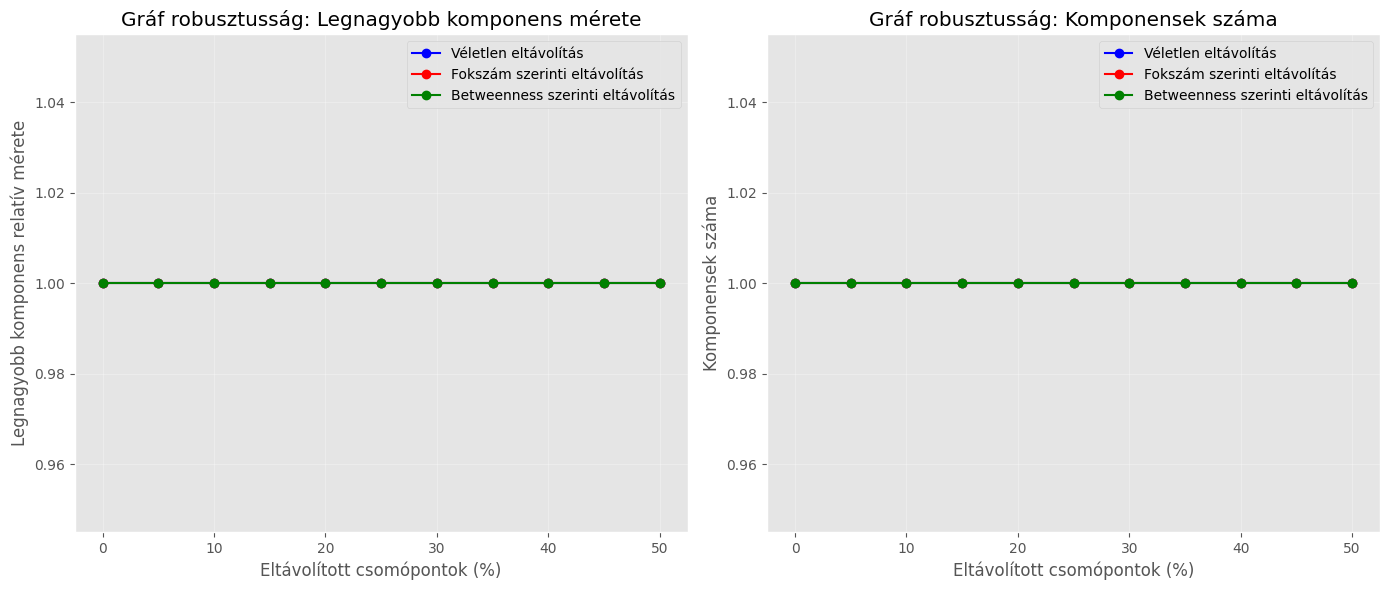


Gráf robusztusság elemzés értelmezése:
1. Minél gyorsabban csökken a legnagyobb komponens mérete, annál sebezhetőbb a gráf
2. A fokszám vagy betweenness szerinti célzott támadás általában hatékonyabb a gráf szétdarabolásában
3. A komponensek száma először nő (a gráf fragmentálódik), majd csökken (az izolált csomópontok eltűnnek)


In [12]:
if G is not None and G.number_of_nodes() > 0:
    print("Gráf robusztusság elemzés...")
    
    # Kisebb gráf létrehozása a vizualizációhoz
    # Ha a gráf nagy, akkor mintát veszünk vagy a legnagyobb komponenst használjuk
    use_sample = False
    sample_size = 1000
    
    if G.number_of_nodes() > sample_size:
        use_sample = True
        print(f"Minta létrehozása a robusztusság teszteléshez ({sample_size} csomópont)...")
        
        # Irányítatlan gráfot használunk az egyszerűbb komponens analízishez
        UG = G.to_undirected()
        
        # Legnagyobb összefüggő komponens azonosítása
        largest_cc = max(nx.connected_components(UG), key=len)
        
        # Ha a legnagyobb komponens még mindig túl nagy, mintát veszünk belőle
        if len(largest_cc) > sample_size:
            sample_nodes = np.random.choice(list(largest_cc), sample_size, replace=False)
            UG_sample = UG.subgraph(sample_nodes)
        else:
            UG_sample = UG.subgraph(largest_cc)
            
        # Győződjünk meg, hogy a mintavétel után is összefüggő maradt
        if not nx.is_connected(UG_sample):
            # Vegyük a legnagyobb összefüggő komponenst
            largest_cc_sample = max(nx.connected_components(UG_sample), key=len)
            UG_sample = UG_sample.subgraph(largest_cc_sample)
        
        print(f"Létrehozott minta mérete: {UG_sample.number_of_nodes()} csomópont, {UG_sample.number_of_edges()} él")
    else:
        UG = G.to_undirected()
        # Nem mintavételezünk, de vegyük a legnagyobb összefüggő komponenst
        if not nx.is_connected(UG):
            largest_cc = max(nx.connected_components(UG), key=len)
            UG_sample = UG.subgraph(largest_cc)
            print(f"Legnagyobb összefüggő komponens használata: {UG_sample.number_of_nodes()} csomópont")
        else:
            UG_sample = UG
            print(f"Az eredeti gráf összefüggő, mérete: {UG_sample.number_of_nodes()} csomópont")
    
    # Robusztusság tesztelése csomópontok eltávolításával
    # Három stratégiát hasonlítunk össze:
    # 1. Véletlen csomópontok eltávolítása
    # 2. Magas fokszámú csomópontok eltávolítása (célzott támadás)
    # 3. Magas betweenness centralitású csomópontok eltávolítása
    
    try:
        # Eredeti gráf tulajdonságai
        n_nodes_orig = UG_sample.number_of_nodes()
        n_edges_orig = UG_sample.number_of_edges()
        largest_cc_size_orig = len(max(nx.connected_components(UG_sample), key=len))
        cc_sizes_orig = [len(cc) for cc in nx.connected_components(UG_sample)]
        avg_path_length_orig = nx.average_shortest_path_length(UG_sample) if nx.is_connected(UG_sample) else float('inf')
        
        print(f"Eredeti gráf: {n_nodes_orig} csomópont, {n_edges_orig} él")
        print(f"Legnagyobb komponens mérete: {largest_cc_size_orig} csomópont ({largest_cc_size_orig/n_nodes_orig:.1%})")
        print(f"Komponensek száma: {len(cc_sizes_orig)}")
        print(f"Átlagos legrövidebb úthossz: {avg_path_length_orig:.4f}")
        
        # Csomópontok eltávolításának lépései (a gráf hány százalékát távolítjuk el)
        removal_steps = np.linspace(0, 0.5, 11)  # 0% - 50% között 11 lépésben
        nodes_to_remove_count = [int(step * n_nodes_orig) for step in removal_steps]
        
        # Különböző eltávolítási stratégiák
        # 1. Véletlen csomópontok
        all_nodes = list(UG_sample.nodes())
        random_nodes = np.random.choice(all_nodes, size=int(removal_steps[-1] * n_nodes_orig), replace=False)
        
        # 2. Magas fokszámú csomópontok
        degree_nodes = sorted(UG_sample.degree(), key=lambda x: x[1], reverse=True)
        high_degree_nodes = [node for node, _ in degree_nodes[:int(removal_steps[-1] * n_nodes_orig)]]
        
        # 3. Magas betweenness csomópontok
        # Nagy gráfoknál ez sokáig tarthat, ezért mintavételezünk a betweenness számításnál
        k_sample = min(500, UG_sample.number_of_nodes() // 2) if UG_sample.number_of_nodes() > 1000 else None
        betweenness = nx.betweenness_centrality(UG_sample, k=k_sample)
        high_betweenness_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
        high_betweenness_nodes = [node for node, _ in high_betweenness_nodes[:int(removal_steps[-1] * n_nodes_orig)]]
        
        # Eredmények tárolása
        results = {
            'removal_percentage': removal_steps * 100,  # Százalék
            'random_lcc': [],  # Legnagyobb komponens relatív mérete
            'high_degree_lcc': [],
            'high_betweenness_lcc': [],
            'random_cc_count': [],  # Komponensek száma
            'high_degree_cc_count': [],
            'high_betweenness_cc_count': []
        }
        
        # Minden eltávolítási lépésre kiszámoljuk a metrikákat
        for i, num_removed in enumerate(nodes_to_remove_count):
            # Véletlen eltávolítás
            if num_removed > 0:
                G_random = UG_sample.copy()
                G_random.remove_nodes_from(random_nodes[:num_removed])
                
                if G_random.number_of_nodes() > 0:
                    cc_sizes = [len(cc) for cc in nx.connected_components(G_random)]
                    largest_cc_size = max(cc_sizes) if cc_sizes else 0
                    results['random_lcc'].append(largest_cc_size / n_nodes_orig)
                    results['random_cc_count'].append(len(cc_sizes))
                else:
                    results['random_lcc'].append(0)
                    results['random_cc_count'].append(0)
            else:
                # Kezdeti, eredeti érték
                results['random_lcc'].append(largest_cc_size_orig / n_nodes_orig)
                results['random_cc_count'].append(len(cc_sizes_orig))
            
            # Magas fokszám szerinti eltávolítás
            if num_removed > 0:
                G_degree = UG_sample.copy()
                G_degree.remove_nodes_from(high_degree_nodes[:num_removed])
                
                if G_degree.number_of_nodes() > 0:
                    cc_sizes = [len(cc) for cc in nx.connected_components(G_degree)]
                    largest_cc_size = max(cc_sizes) if cc_sizes else 0
                    results['high_degree_lcc'].append(largest_cc_size / n_nodes_orig)
                    results['high_degree_cc_count'].append(len(cc_sizes))
                else:
                    results['high_degree_lcc'].append(0)
                    results['high_degree_cc_count'].append(0)
            else:
                results['high_degree_lcc'].append(largest_cc_size_orig / n_nodes_orig)
                results['high_degree_cc_count'].append(len(cc_sizes_orig))
            
            # Magas betweenness szerinti eltávolítás
            if num_removed > 0:
                G_betweenness = UG_sample.copy()
                G_betweenness.remove_nodes_from(high_betweenness_nodes[:num_removed])
                
                if G_betweenness.number_of_nodes() > 0:
                    cc_sizes = [len(cc) for cc in nx.connected_components(G_betweenness)]
                    largest_cc_size = max(cc_sizes) if cc_sizes else 0
                    results['high_betweenness_lcc'].append(largest_cc_size / n_nodes_orig)
                    results['high_betweenness_cc_count'].append(len(cc_sizes))
                else:
                    results['high_betweenness_lcc'].append(0)
                    results['high_betweenness_cc_count'].append(0)
            else:
                results['high_betweenness_lcc'].append(largest_cc_size_orig / n_nodes_orig)
                results['high_betweenness_cc_count'].append(len(cc_sizes_orig))
        
        # Eredmények vizualizálása
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(results['removal_percentage'], results['random_lcc'], 'bo-', label='Véletlen eltávolítás')
        plt.plot(results['removal_percentage'], results['high_degree_lcc'], 'ro-', label='Fokszám szerinti eltávolítás')
        plt.plot(results['removal_percentage'], results['high_betweenness_lcc'], 'go-', label='Betweenness szerinti eltávolítás')
        plt.grid(True, alpha=0.3)
        plt.xlabel('Eltávolított csomópontok (%)')
        plt.ylabel('Legnagyobb komponens relatív mérete')
        plt.title('Gráf robusztusság: Legnagyobb komponens mérete')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(results['removal_percentage'], results['random_cc_count'], 'bo-', label='Véletlen eltávolítás')
        plt.plot(results['removal_percentage'], results['high_degree_cc_count'], 'ro-', label='Fokszám szerinti eltávolítás')
        plt.plot(results['removal_percentage'], results['high_betweenness_cc_count'], 'go-', label='Betweenness szerinti eltávolítás')
        plt.grid(True, alpha=0.3)
        plt.xlabel('Eltávolított csomópontok (%)')
        plt.ylabel('Komponensek száma')
        plt.title('Gráf robusztusság: Komponensek száma')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Értelmezés
        print("\nGráf robusztusság elemzés értelmezése:")
        print("1. Minél gyorsabban csökken a legnagyobb komponens mérete, annál sebezhetőbb a gráf")
        print("2. A fokszám vagy betweenness szerinti célzott támadás általában hatékonyabb a gráf szétdarabolásában")
        print("3. A komponensek száma először nő (a gráf fragmentálódik), majd csökken (az izolált csomópontok eltűnnek)")
        
    except Exception as e:
        print(f"Hiba a robusztusság elemzés során: {e}")
        
else:
    print('A gráf nincs betöltve vagy üres.')